In [1]:
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
%matplotlib inline

# declare a class for molecules
class Molecule:
    
        def __init__(self):
                #start by defining some physical constants
                self.R = 8.3144621E-3 #ideal Gas constant in kJ/mol-K
                self.kB = 1.38065e-23 #Boltzmann constant in J/K
                self.h = 6.62607e-34 #Planck constant in J*s
                self.c = 2.99792458e8 #speed of light in m/s
                self.amu = 1.6605e-27 #atomic mass unit in kg
                self.Avogadro = 6.0221E23 #mole^-1
                self.GHz_to_Hz = 1.0E9 #convert rotational constants from GHz to Hz
                self.invcm_to_invm = 1.0E2 #convert cm^-1 to m^-1, for frequencies
                self.P_ref = 1.0E5 #reference pressure, 1 bar = 1E5 Pascal
                self.hartree_to_kcalpermole = 627.5095 #convert hartree/molecule to kcal/mol
                self.hartree_to_kJpermole = 2627.25677 #convert hartree/molecule to kJ/mol
                self.eV_to_kJpermole = 96.485 #convert eV/molecule to kJ/mol
                self.T_switch = 1000.0 #K, switching temperature in NASA polynomial. Default. can overwrite.
                self.site_occupation_number = 1 #number of sites occupied by adsorbate
                self.unit_cell_area = {'Ni111': 48.55968e-20/9.0, 'Ni100': 56.070144e-20/9.0,'Ni110': 79.29792e-20/9.0, 'Ni211': 45.781632e-20/9.0} #m2 - using surface area per binding site (nine binding sites per cell)
                self.cutoff_frequency = 100.0 #cm^-1
                self.twoD_gas = False
                self.eV_to_kJpermole = 96.485 #convert eV/molecule to kJ/mol
                self.molecular_mass_elements = {'H': 1.01, 'C': 12.01, 'N': 14, 'O': 16}
                
                #Pt is just a surface site X. I'm too lazy to change all the files now
                self.reference_energies= {"Ni111": {"XCO":-92.868 ,"XO":-84.800, "XH": 0, "Pt":-79.348378},
                                          "Ni100": {"XCO":-89.301 ,"XO":-81.548, "XH": 0, "Pt":-75.766845},
                                          "Ni110": {"XCO":-81.954 ,"XO":-73.707, "XH": 0, "Pt":-68.400016},
                                          "Ni211": {"XCO":-91.922 ,"XO":-83.778, "XH": 0, "Pt": -78.430421},
                                         }
                
                self.reference_EOF={"Ni111": {"XCO":-231.9 ,"XO":-237.9, "XH": 0, "Pt":0},
                                    "Ni100": {"XCO":-238.8 ,"XO":-263.6, "XH": 0, "Pt":0},
                                    "Ni110": {"XCO":-240.4 ,"XO":-233.7, "XH": 0, "Pt":0},
                                    "Ni211": {"XCO":-254.3 ,"XO":-308.7, "XH": 0, "Pt":0},
                                    }
                
                self.reference_compositions={"XCO": {"C": 1,  "O": 1, "H":0, "Pt": 1},
                                             "XO": {"C": 0, "O": 1, "H":0, "Pt": 1},
                                             "XH": {"C": 0, "O": 0, "H":1, "Pt": 1},
                                             "X": {"C": 0, "O": 0, "H":0, "Pt": 1},
                                             }
                
# create the array of temperatures in 10 degree increments
temperature = [298.15] #NOTE 298.15 must be first for the NASA polynomial routine to work!
T_low = 300.0
T_high = 2000.0
dT = 10.0 #temperature increment
temperature = np.append(temperature, np.arange(T_low, T_high+dT, dT) )                

In [2]:
# HERE BEGINS THE LONG LIST OF SUBROUTINES

def compute_thermo(molecule):
    
    # Create an array to hold the elemental compositions of the target species
    num_elements = 4  # C, O, H, X ##hardcoded for now

    # Fill in the elemental composition matrix of the target species
    N = np.array([molecule.composition["C"], molecule.composition["O"], molecule.composition["H"], molecule.composition["Pt"]])

    references=list(molecule.reference_compositions.keys())

    # Create a matrix to hold the elemental compositions of the reference species
    num_references = len(molecule.reference_compositions)
    N_R = np.zeros((num_references, num_elements))
    
    for s, composition in molecule.reference_compositions.items():
        i = references.index(s)
        N_R[i,:] = np.array([composition["C"], composition["O"],
                            composition["H"], composition["Pt"]])
        
    #Calculate the matrix of stoichiometric coefficients to form the target from the reference species
    M=-N.dot(np.linalg.inv(N_R)) 
    
    H_ref=np.array(list(molecule.reference_EOF[molecule.facet].values()))
    E_ref=np.array(list(molecule.reference_energies[molecule.facet].values()))
    
    E=np.array(molecule.DFT_energy+molecule.ZPE_energy)
    
    #Determine the enthalpy of formation of the target
    molecule.heat_of_formation_0K=(E*molecule.eV_to_kJpermole+M.dot(E_ref)*molecule.eV_to_kJpermole-M.dot(H_ref))
  
    print(f"heat of formation adsorbate= {molecule.heat_of_formation_0K:.4} kJ/mol")
    
    return

#-------------------------------------------------------------------------
# subroutine for the translational mode
def get_translation_thermo(molecule,temperature):
    # unpack the constants (not essential, but makes it easier to read)
    R = molecule.R
    kB = molecule.kB
    h = molecule.h
    amu = molecule.amu
    P_ref = molecule.P_ref
    m = molecule.adsorbate_mass
    pi = np.pi
    area = molecule.unit_cell_area
    sites = molecule.site_occupation_number

    if molecule.facet == 'Ni111':
        area = molecule.unit_cell_area['Ni111']
    elif molecule.facet == 'Ni100':
        area = molecule.unit_cell_area['Ni100']
    elif molecule.facet == 'Ni110':
        area = molecule.unit_cell_area['Ni110']
    elif molecule.facet == 'Ni211':
        area = molecule.unit_cell_area['Ni211']
    else:
        print('Please provide the right facet!')
        
    #initialize the arrays for the partition function, entropy, enthalpy,
    #and heat capacity.
    Q_trans  = np.ones(len(temperature)) 
    S_trans  = np.zeros(len(temperature))
    dH_trans  = np.zeros(len(temperature))
    Cp_trans  = np.zeros(len(temperature))

    if molecule.twoD_gas:
        print("switching to 2D-gas for 2 lowest modes for %s"%molecule.name)
        # cycle through each temperature
        for (i,T) in enumerate(temperature):
            # partition function is: (2*pi*mass*kB*T/h**2)^(2/2) * area
            if (1==0): #3D gas, really here just for inspiration
                V = kB*T/P_ref
                Q_trans[i] = (2*pi*m*amu*kB*T/h**2)**(1.5) * V
                S_trans[i] = R * (2.5 + np.log( Q_trans[i] )) #
                Cp_trans[i] = R * 2.5 #NOTE: Cp = Cv + R
                dH_trans[i] = R * 2.5 * T      
            else: #surface
                if (1==0): #Campbell + Arnadottir
                    V = kB*T/P_ref
                    Q_trans[i] = (2*pi*m*amu*kB*T/h**2)**(1.0) *V**0.66667
                    S_trans[i] = R * (2.0 + np.log( Q_trans[i] ))
                    Cp_trans[i] = R * 1.66667 #NOTE: Cp = Cv + 2/3R
                    dH_trans[i] = R * 1.66667 * T            
        
                else: #area is not a function of temperature (This is what we use for our calculations)
                    Q_trans[i] = (2*pi*m*amu*kB*T/h**2) * area * sites
                    S_trans[i] = R * (2.0 + np.log( Q_trans[i] ))
                    Cp_trans[i] = R * 1.0 #NOTE: Cp = Cv 
                    dH_trans[i] = R * 1.0 * T            

    # add the results to the thermo object
    molecule.Q_trans = Q_trans
    molecule.S_trans = S_trans
    molecule.dH_trans = dH_trans
    molecule.Cp_trans = Cp_trans 
    

    return


# subroutine for the vibrational mode
def get_vibrational_thermo(molecule,temperature):
    units = 1.0
    units *= molecule.h * molecule.c / molecule.kB * molecule. invcm_to_invm # K * cm
    amu = molecule.amu
    kB = molecule.kB
    h = molecule.h
    P_ref = molecule.P_ref
    mass = float(molecule.adsorbate_mass)
    
    
    #initialize the arrays for the partition function, entropy, enthalpy,
    #and heat capacity.
    Q_vib  = np.ones(len(temperature))
    S_vib  = np.zeros(len(temperature))
    dH_vib  = np.zeros(len(temperature))
    Cv_vib  = np.zeros(len(temperature))
    
    for (t,temp) in enumerate(temperature):
        for (n,nu) in enumerate(molecule.frequencies):
            if molecule.twoD_gas==True and n <= 1: #skip the first two if we do 2D gas
                #do nothing!
                Q_vib[t] *= 1.0
                S_vib[t] += 0.0
                dH_vib[t] += 0.0
                Cv_vib[t] += 0.0
            else:
                x = nu * units / temp #cm^-1 * K cm / K = dimensionless
                Q_vib[t]  *= 1.0 / (1.0 - np.exp( - x) )
                S_vib[t]  += -np.log( 1.0 - np.exp( - x ) ) + x * np.exp( - x) / (1.0 - np.exp( - x) ) 
                dH_vib[t] += x * np.exp( - x) / (1.0 - np.exp( - x) ) 
                Cv_vib[t] += x**2.0 * np.exp( - x) / (1.0 - np.exp( - x) )**2.0
        S_vib[t]  *= molecule.R
        dH_vib[t] *= molecule.R * temp
        Cv_vib[t] *= molecule.R
    
    # add the results to the thermo object
    molecule.Q_vib = Q_vib
    molecule.S_vib = S_vib
    molecule.dH_vib = dH_vib
    molecule.Cv_vib = Cv_vib #NOTE: the correction from Cv to Cp is handled in the translation partition function.
                             #if the molecule is tightly bound and thus the 2D-gas is not used, 
                             #then we assume that Cp=Cv for the adsorbate.

    return

#-------------------------------------------------------------------------
#create the main thermo function that calls the individual modes
def thermo(molecule, temperature):
    compute_thermo(molecule)
    #calculate the molecular mass
    molecule.adsorbate_mass=molecule.composition['H']*molecule.molecular_mass_elements['H']
    molecule.adsorbate_mass+=molecule.composition['O']*molecule.molecular_mass_elements['O']
    molecule.adsorbate_mass+=molecule.composition['C']*molecule.molecular_mass_elements['C']
    molecule.adsorbate_mass+=molecule.composition['N']*molecule.molecular_mass_elements['N']
    print(f"Molecular mass= {molecule.adsorbate_mass:.4} g/mol" )
    # call the subroutine for the translational and vibrational partition functions
    get_translation_thermo(molecule,temperature)
    get_vibrational_thermo(molecule,temperature)

    
    #now compute the correction to the heat of formation as you go from 0 to 298 K
    h_correction = 4.234 #kJ/mol. enthalpy_H(298) - enthalpy_H(0)
    c_correction = 1.051 #kJ/mol. enthalpy_C(298) - enthalpy_C(0)
    n_correction = 4.335 #kJ/mol. enthalpy_N(298) - enthalpy_N(0)
    o_correction = 4.340 #kJ/mol. enthalpy_O(298) - enthalpy_O(0)
    
    molecule.heat_of_formation_correction = 0.0
    molecule.heat_of_formation_correction += molecule.composition['H'] * h_correction
    molecule.heat_of_formation_correction += molecule.composition['C'] * c_correction    
    molecule.heat_of_formation_correction += molecule.composition['N'] * n_correction
    molecule.heat_of_formation_correction += molecule.composition['O'] * o_correction        
    
    # note that the partition function is the production of the individual terms,
    # whereas the thermodynamic properties are additive
    molecule.Q = molecule.Q_trans * molecule.Q_vib 
    molecule.S = molecule.S_trans + molecule.S_vib 
    molecule.dH = molecule.dH_trans + molecule.dH_vib 
    molecule.Cp = molecule.Cp_trans + molecule.Cv_vib # see comments in each section regarding Cp vs Cv
    molecule.heat_of_formation_298K = molecule.heat_of_formation_0K + molecule.dH[0] - molecule.heat_of_formation_correction
    molecule.H = molecule.heat_of_formation_298K + molecule.dH - molecule.dH[0]
    
    #print(molecule.heat_of_formation_298K)
    #print(molecule.H[0])
    print(np.round(molecule.heat_of_formation_298K-molecule.heat_of_formation_0K,2))
    print(f"Entropy = {molecule.S[0]*1e3:.3} J/K/mol")
    #This writes H_298, S_298 and appropriate indices of Cp to file (preparation for computing adsorption corrections)
    g = open("Pt_thermodata_adsorbates.py",'a+')
    g.write('[' + str(molecule.name) + ', Cpdata:, ' +  str(molecule.Cp[np.where(temperature==300)]*239.0057)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==400)]*239.0057)[1:-1] + ', '+ str(molecule.Cp[np.where(temperature==500)]*239.0057)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==600)]*239.0057)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==800)]*239.0057)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==1000)]*239.0057)[1:-1] + ', ' + str(molecule.Cp[np.where(temperature==1500)]*239.0057)[1:-1] + ', ' + ",'cal/(mol*K)', H298, " + str(molecule.H[0]*0.2390057) + ", 'kcal/mol', S298, " + str(molecule.S[0]*239.0057) + ", 'cal/(mol*K)']")
    g.write('\n')
    g.close()
    
    # now that we've computed the thermo properties, go ahead and fit them to a NASA polynomial
    fit_NASA(temperature, molecule)
    format_rmg_output(molecule)
    return

#-------------------------------------------------------------------------
#compute thermo properties from nasa polynomials
def get_thermo_from_NASA(temperature, molecule):

    a_low = molecule.a_low
    a_high = molecule.a_high
    R = molecule.R
    T_switch = molecule.T_switch
    
    i_switch = -1
    for i in range(len(temperature)):
        if temperature[i]==T_switch:
            i_switch = i
    
    cp_fit = np.zeros(len(temperature))
    h_fit = np.zeros(len(temperature))
    s_fit = np.zeros(len(temperature))
    for (i,temp) in enumerate(temperature):
        if temp <= T_switch:
            cp_fit[i] = a_low[0] + a_low[1]*temp + a_low[2]*temp**2.0  + a_low[3]*temp**3.0  + a_low[4]*temp**4.0
            h_fit[i] = a_low[0]*temp + a_low[1]/2.0*temp**2.0 + a_low[2]/3.0*temp**3.0  + a_low[3]/4.0*temp**4.0  + a_low[4]/5.0*temp**5.0 + a_low[5]
            s_fit[i] = a_low[0]*np.log(temp) + a_low[1]*temp + a_low[2]/2.0*temp**2.0  + a_low[3]/3.0*temp**3.0  + a_low[4]/4.0*temp**4.0 + a_low[6]
        else:
            cp_fit[i] = a_high[0] + a_high[1]*temp + a_high[2]*temp**2.0  + a_high[3]*temp**3.0  + a_high[4]*temp**4.0
            h_fit[i] = a_high[0]*temp + a_high[1]/2.0*temp**2.0 + a_high[2]/3.0*temp**3.0  + a_high[3]/4.0*temp**4.0  + a_high[4]/5.0*temp**5.0 + a_high[5]
            s_fit[i] = a_high[0]*np.log(temp) + a_high[1]*temp + a_high[2]/2.0*temp**2.0  + a_high[3]/3.0*temp**3.0  + a_high[4]/4.0*temp**4.0 + a_high[6]

    cp_fit *= R        
    h_fit *= R  
    s_fit *= R  
    
    molecule.Cp_fit = cp_fit
    molecule.H_fit = h_fit
    molecule.S_fit = s_fit
    return 


#-------------------------------------------------------------------------
#fit nasa coefficients
def fit_NASA(temperature, molecule):
    
    R = molecule.R
    heat_capacity = molecule.Cp
    reference_enthalpy = molecule.H[0]
    reference_entropy = molecule.S[0]
    T_switch = molecule.T_switch
    
    i_switch = -1
    for i in range(len(temperature)):
        if temperature[i]==T_switch:
            i_switch = i
    if i_switch==-1:
        print("We have a problem! Cannot find switching temperature")
        
    
    #start by creating the independent variable matrix for the low-temperature fit
    YT = np.array( [ np.ones(len(temperature[:i_switch+1])), temperature[:i_switch+1], temperature[:i_switch+1]**2.0, temperature[:i_switch+1]**3.0, temperature[:i_switch+1]**4.0 ],dtype=np.float64 ) #this is transpose of our Y
    Y = YT.transpose() #this is the desired Y

    b = heat_capacity[:i_switch+1] / R  
    a_low = np.linalg.lstsq(Y, b, rcond=None)[0]

    T_ref = 298.15
    #now determine the enthalpy coefficient for the low-T region
    subtract = a_low[0] + a_low[1]/2.0*T_ref + a_low[2]/3.0*T_ref**2.0 + a_low[3]/4.0*T_ref**3.0  + a_low[4]/5.0*T_ref**4.0
    a_low = np.append(a_low, reference_enthalpy / R - subtract * T_ref)
    #now determine the entropy coefficient for the low-T region
    subtract = a_low[0] * np.log(T_ref) + a_low[1]*T_ref     + a_low[2]/2.0*T_ref**2.0  + a_low[3]/3.0*T_ref**3.0  + a_low[4]/4.0*T_ref**4.0
    a_low = np.append(a_low, reference_entropy / R - subtract )

    #
    # NOW SWITCH TO HIGH-TEMPERATURE REGIME!
    #
    T_ref = T_switch
    #compute the heat capacity, enthalpy, and entropy at the switching point
    Cp_switch = a_low[0] + a_low[1]*T_ref + a_low[2]*T_ref**2.0  + a_low[3]*T_ref**3.0  + a_low[4]*T_ref**4.0
    H_switch = a_low[0]*T_ref + a_low[1]/2.0*T_ref**2.0 + a_low[2]/3.0*T_ref**3.0  + a_low[3]/4.0*T_ref**4.0  + a_low[4]/5.0*T_ref**5.0 + a_low[5]
    S_switch = a_low[0]*np.log(T_ref) + a_low[1]*T_ref + a_low[2]/2.0*T_ref**2.0  + a_low[3]/3.0*T_ref**3.0  + a_low[4]/4.0*T_ref**4.0 + a_low[6]
    
    #now repeat the process for the high-temperature regime
    a_high = [0.0]
    YT = np.array( [ temperature[i_switch:], temperature[i_switch:]**2.0, temperature[i_switch:]**3.0, temperature[i_switch:]**4.0 ],dtype=np.float64 ) #this is transpose of our Y
    Y = YT.transpose() #this is the desired Y

    b = heat_capacity[i_switch:] / R - Cp_switch
    a_high = np.append(a_high, np.linalg.lstsq(Y, b, rcond=None)[0])
    a_high[0] = Cp_switch - (a_high[0] + a_high[1]*T_switch + a_high[2]*T_switch**2.0  + a_high[3]*T_switch**3.0  + a_high[4]*T_switch**4.0)
    
    a_high = np.append(a_high, H_switch - (a_high[0] + a_high[1]/2.0*T_ref + a_high[2]/3.0*T_ref**2.0  + a_high[3]/4.0*T_ref**3.0  + a_high[4]/5.0*T_ref**4.0)*T_ref )
    a_high = np.append(a_high, S_switch - (a_high[0]*np.log(T_ref) + a_high[1]*T_ref + a_high[2]/2.0*T_ref**2.0  + a_high[3]/3.0*T_ref**3.0  + a_high[4]/4.0*T_ref**4.0) )

    #Check to see if there is a discontinuity
    if (1==0):
        print("\ncheck for discontinuities:")
        cp_low_Tswitch = a_low[0] + a_low[1]*T_switch + a_low[2]*T_switch**2.0  + a_low[3]*T_switch**3.0  + a_low[4]*T_switch**4.0
        cp_high_Tswitch = a_high[0] + a_high[1]*T_switch + a_high[2]*T_switch**2.0  + a_high[3]*T_switch**3.0  + a_high[4]*T_switch**4.0
        H_low_Tswitch = a_low[0]*T_switch + a_low[1]/2.0*T_switch**2.0 + a_low[2]/3.0*T_switch**3.0  + a_low[3]/4.0*T_switch**4.0  + a_low[4]/5.0*T_switch**5.0 + a_low[5]
        H_high_Tswitch = a_high[0]*T_switch + a_high[1]/2.0*T_switch**2.0 + a_high[2]/3.0*T_switch**3.0  + a_high[3]/4.0*T_switch**4.0  + a_high[4]/5.0*T_switch**5.0 + a_high[5]
        S_low_Tswitch = a_low[0]*np.log(T_switch) + a_low[1]*T_switch + a_low[2]/2.0*T_switch**2.0  + a_low[3]/3.0*T_switch**3.0  + a_low[4]/4.0*T_switch**4.0 + a_low[6]
        S_high_Tswitch = a_high[0]*np.log(T_switch) + a_high[1]*T_switch + a_high[2]/2.0*T_switch**2.0  + a_high[3]/3.0*T_switch**3.0  + a_high[4]/4.0*T_switch**4.0 + a_high[6]    

        print("discontinuity at T_switch for Cp/R is %.4F"%(cp_low_Tswitch - cp_high_Tswitch))
        print("discontinuity at T_switch for H/R is %.4F"%(H_low_Tswitch - H_high_Tswitch))   
        print("discontinuity at T_switch for S/R is %.4F"%(S_low_Tswitch - S_high_Tswitch))        

    
    line = '    thermo = NASA(\n'
    line += "        polynomials = [\n"
    line += "            NASAPolynomial(coeffs=[%.8E, %.8E, %.8E, %.8E, %.8E, %.8E, %.8E], Tmin=(%.1F, 'K'), Tmax=(%.1F, 'K')), \n"%(a_low[0], a_low[1], a_low[2], a_low[3], a_low[4], a_low[5], a_low[6], 298.0, 1000.0)
    line += "            NASAPolynomial(coeffs=[%.8E, %.8E, %.8E, %.8E, %.8E, %.8E, %.8E], Tmin=(%.1F, 'K'), Tmax=(%.1F, 'K')), \n"%(a_high[0], a_high[1], a_high[2], a_high[3], a_high[4], a_high[5], a_high[6], 1000.0, max(temperature))
    line += "        ],\n"
    line += "        Tmin = (%.1F,'K'),\n"%(298)
    line += "        Tmax = (%.1F,'K'),\n"%(max(temperature))
    line += "    ),\n"
    
    
    molecule.thermo_lines = line
    
    molecule.a_low = a_low
    molecule.a_high = a_high
    
    return 


#-------------------------------------------------------------------------
#compare NASA fits to computed fits
def compare_NASA_to_thermo(temperature, molecule):
    
    fig = pylab.figure(dpi=300,figsize=(12,4))
    gs = gridspec.GridSpec(1, 3)
    gs.update(wspace=0.5, hspace=0.4)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    if (1==1): #use this to plot the absolute curves
        ax0.plot(temperature, molecule.Cp, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None',label='stat. mech.')
        ax0.plot(temperature, molecule.Cp_fit, 'b', linewidth=2,label='NASA')
        ax1.semilogy(temperature, molecule.H - molecule.heat_of_formation_298K, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None')
        ax1.semilogy(temperature, molecule.H_fit - molecule.heat_of_formation_298K, 'b', linewidth=2)
        ax2.semilogy(temperature, molecule.S, marker='o', markeredgecolor='r',color='w',alpha=0.5,linestyle='None')
        ax2.semilogy(temperature, molecule.S_fit, 'b', linewidth=2)
        ax0.set_ylim(min(molecule.Cp_fit)*0.9, max(molecule.Cp_fit)*1.025)
        ax1.set_ylim(top=max(molecule.H - molecule.heat_of_formation_298K)*1.025)
        ax2.set_ylim(10e-3*0.9, max(molecule.S_fit)*1.025)
        ax1.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))
        ax2.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))
        
    else: #use this one to plot the percent change    
        ax0.plot(temperature, 1.0 - molecule.Cp/molecule.Cp_fit, 'b', linewidth=2)
        ax1.plot(temperature, 1.0 - molecule.H/molecule.H_fit, 'b', linewidth=2)
        ax2.plot(temperature, 1.0 - molecule.S/molecule.S_fit, 'b', linewidth=2)
        ax0.set_ylim(-5E-3, 5E-3)
        ax1.set_ylim(-5E-3, 5E-3)
        ax2.set_ylim(-5E-3, 5E-3)
        ax1.yaxis.set_major_locator(MaxNLocator(4))
        ax2.yaxis.set_major_locator(MaxNLocator(4))
        
    # now make it look better
    ax0.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax0.xaxis.set_major_locator(MaxNLocator(4))
    ax0.yaxis.set_major_locator(MaxNLocator(4))
    ax0.tick_params(axis='both', which='major', labelsize=12)
    #ax0.set_title("heat capacity")
    ax0.set_xlabel("temperature (K)", fontsize=12)
    ax0.set_ylabel('$\mathrm{heat\ capacity\, (JK^{-1}mol{-1})}$', fontsize=12)
    ax0.legend()
    
    ax1.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax1.xaxis.set_major_locator(MaxNLocator(4))
    ax1.tick_params(axis='both', which='major', labelsize=12)
    #ax1.set_title("change in enthalpy")
    ax1.set_xlabel("temperature (K)", fontsize=12)
    ax1.set_ylabel('$\mathrm{change\ in\ enthalpy\, (Jmol{-1})}$', fontsize=12)
    
    ax2.set_xlim(min(temperature)*0.95, max(temperature)*1.025)
    ax2.xaxis.set_major_locator(MaxNLocator(4))
    ax2.tick_params(axis='both', which='major', labelsize=12)
    #ax2.set_title("entropy")
    ax2.set_xlabel("temperature (K)", fontsize=12)
    ax2.set_ylabel('$\mathrm{entropy\, (JK^{-1}mol{-1})}$', fontsize=12)
    
    plt.savefig('test.png',bbox_inches='tight',dpi=300,transparent=False)
    
    return

def format_rmg_output(molecule):
    
    line = '\n'
    line += 'species(name = "%s",\n'%(molecule.name)
    line += '\tatoms = "'
    for element in molecule.composition:
        if molecule.composition[element]>0:
            line += " %s:%d"%(element, molecule.composition[element])
    line += '",\n'
    line += "\tsize = %d,\n"%(molecule.site_occupation_number)
    line += molecule.thermo_lines
    line += '    longDesc = u"""Calculated by Bjarne Kreitz at Brown University using statistical mechanics (file: ThermoPt111.py).\n'
    line += "            Based on DFT calculations by Bjarne Kreitz from Brown University. DFT calculations were performed with Quantum Espresso\n"
    line += "            using PAW pseudopotentials and the BEEF-vdW functional for an optimized 3x3 supercell (1/9ML coverage)\n"
    line += "            following the procedure outlined by Blondal et al (DOI:10.1021/acs.iecr.9b01464). The following settings were applied:\n"    
    line += "            kpoints=(5x5x1), 4 layers (2 bottom layers fixed), ecutwfc=60 Ry, smearing='mazari-vanderbilt', mixing_mode='local-TF',\n"
    line += "            fmax=2.5e-2. \n" 
    if molecule.twoD_gas:
        line += '\n            The two lowest frequencies, %.1F and %.1F %s, where replaced by the 2D gas model.\n' %(molecule.frequencies[0], molecule.frequencies[1], molecule.frequencies_units.replace("'",""))
    line += '""",\n'
    line += '    metal = "Pt",\n'
    line += '    facet = "111",\n)\n'   
    
    molecule.species_lines = line
    
    return

def parse_input_file(inputfile, molecule):
    
    import os
    script_dir='dft-data/'
    rel_path = str(script_dir) + str(inputfile) 
    abs_file_path = os.path.join(rel_path)
    
    input_file = open(abs_file_path,'r')
    lines = input_file.readlines()
    input_file.close()
    
    error_name = True
    error_DFT_energy = True
    error_ZPE_energy = True
    error_DFT_energy_gas = True
    error_ZPE_energy_gas = True
    error_composition = True
    error_sites = True
    error_coverage = True
    error_facet = True
    
    for line in lines:
        #start by looking for the name
        if line.strip().startswith("name"):
            bits = line.split('=')
            name = bits[1].strip().replace("'","").replace('"','')
            molecule.name = name
            error_name = False
        #now look for the DFT energy    
        elif line.strip().startswith("DFT_energy"):
            bits = line.split('=') 
            DFT_energy_info = bits[1].strip().replace("[","").replace("]","").split(',')
            DFT_energy = float(DFT_energy_info[0])
            units = DFT_energy_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.DFT_energy = DFT_energy
                molecule.DFT_energy_units = units.strip()
                error_DFT_energy = False
            else:
                print ("DFT energy is missing proper units!\n Please use 'eV'")
                break
           
        #now look for the ZPE energy    
        elif line.strip().startswith("ZPE_energy"):
            bits = line.split('=') 
            ZPE_energy_info = bits[1].strip().replace("[","").replace("]","").split(',')
            ZPE_energy = float(ZPE_energy_info[0])
            units = ZPE_energy_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.ZPE_energy = ZPE_energy
                molecule.ZPE_energy_units = units.strip()
                error_ZPE_energy = False
            else:
                print ("ZPE energy is missing proper units!\n Please use 'eV'")
                break
                
        #now look for the DFT energy    
        elif line.strip().startswith("gas_DFT_energy"):
            bits = line.split('=') 
            DFT_energy_gas_info = bits[1].strip().replace("[","").replace("]","").split(',')
            DFT_energy_gas = float(DFT_energy_gas_info[0])
            units = DFT_energy_gas_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.DFT_energy_gas = DFT_energy_gas
                molecule.DFT_energy_gas_units = units.strip()
                error_DFT_energy_gas = False
            else:
                print ("gas DFT energy is missing proper units!\n Please use 'eV'")
                break
           
        #now look for the ZPE energy    
        elif line.strip().startswith("gas_ZPE_energy"):
            bits = line.split('=') 
            ZPE_energy_gas_info = bits[1].strip().replace("[","").replace("]","").split(',')
            ZPE_energy_gas = float(ZPE_energy_gas_info[0])
            units = ZPE_energy_gas_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.ZPE_energy_gas = ZPE_energy_gas
                molecule.ZPE_energy_gas_units = units.strip()
                error_ZPE_energy_gas = False
            else:
                print ("gas ZPE energy is missing proper units!\n Please use 'eV'")
                break
                
        #now look for the composition    
        elif line.strip().startswith("composition"):
            bits = line.split('=') 
            composition = bits[1].strip().replace("{","").replace("}","").split(',')
            molecule.composition = {}
            for pair in composition:
                element, number = pair.split(":")
                element = element.strip().replace("'","").replace('"','')
                number = int(number)
                molecule.composition[element]=number
            N_adsorbate_atoms = 0
            for element in molecule.composition:
                if element!='Pt':
                    N_adsorbate_atoms += molecule.composition[element]            
            error_composition = False

        #now look for the coverage    
        elif line.strip().startswith("coverage"):
            bits = line.split('=') 
            coverage_info = bits[1].strip()
            coverage = int(coverage_info[0])
            molecule.coverage = coverage
            error_coverage = False
       
        #now look for the facet 
        elif line.strip().startswith("facet"):
            bits = line.split('=') 
            facet_info = bits[1].strip().replace("[","").replace("]","").replace("'","")
            facet = str(facet_info)
            molecule.facet = facet
            error_facet = False
    
        elif line.strip().startswith("frequencies"):
            bits = line.split('=')
            freq_info = bits[1].strip().replace("[","").replace("]","").split(',')
            N_freq_computed = coverage*3*N_adsorbate_atoms
            if len(freq_info)!=N_freq_computed+1:
                print("ERROR: The number of frequencies is not what was expected\n %d expected, but only %d received"%(N_freq_computed, len(freq_info)-1))
            units = freq_info[-1]    
            if units=='eV' or units!='cm-1':
                molecule.frequencies_units = units.strip()
                molecule.frequencies_raw = []
                for i in range(len(freq_info)-1):
                    molecule.frequencies_raw.append(float(freq_info[i]))                   
                   
                molecule.frequencies = []
                for i in range(0, len(molecule.frequencies_raw), int(coverage)):
                    group = molecule.frequencies_raw[i:i+int(coverage)]
                    average = sum(group) / coverage
                    molecule.frequencies.append(average)

                error_frequencies = False
                #if the two lowest frequencies are less than the cutoff value (This assumes that they are sorted!)
                if molecule.frequencies[1]<molecule.cutoff_frequency:
                    print("switching to 2D-gas for 2 lowest modes for %s"%name)
                    molecule.twoD_gas = True
                    
                    
    if error_name or error_DFT_energy or error_ZPE_energy or error_DFT_energy_gas or error_ZPE_energy_gas or error_composition:
        print ("Input file is missing information: %s"%(inputfile))
    else:
        print ("successfully parsed file %s"%(inputfile))    
    return

In [81]:
test = Molecule()
parse_input_file('Ni111/CO_19.dat',test)
thermo(test, temperature)
get_thermo_from_NASA(temperature, test)
#compare_NASA_to_thermo(temperature, test)

successfully parsed file Ni111/CO_19.dat
heat of formation adsorbate= -231.9 kJ/mol
Molecular mass= 28.01 g/mol
1.32
Entropy = 40.4 J/K/mol


In [82]:
thermo(test, temperature)
#get_thermo_from_NASA(temperature, test)
#compare_NASA_to_thermo(temperature, test)

heat of formation adsorbate= -231.9 kJ/mol
Molecular mass= 28.01 g/mol
1.32
Entropy = 40.4 J/K/mol


In [55]:
#This is the name of the output file
new_output = open('my_new_cti.txt', 'w')

name_line = '\n'
species_line = '\n'

name_line += ' %s'%(test.name)
#species_line += test.species_lines
    
#get_thermo_from_NASA(temperature, test)
#compare_NASA_to_thermo(temperature, test)

name_line += '\n\n' 
new_output.write(name_line)
new_output.write(species_line)

new_output.close()   

Ni111/C_19.dat
successfully parsed file Ni111/C_19.dat
heat of formation adsorbate= 143.1 kJ/mol
Molecular mass= 12.01 g/mol
0.49
Entropy = 7.09 J/K/mol
Ni100/C_19.dat
successfully parsed file Ni100/C_19.dat
heat of formation adsorbate= 6.015 kJ/mol
Molecular mass= 12.01 g/mol
0.78
Entropy = 9.14 J/K/mol
Ni110/C_19.dat
successfully parsed file Ni110/C_19.dat
heat of formation adsorbate= 87.43 kJ/mol
Molecular mass= 12.01 g/mol
1.08
Entropy = 10.4 J/K/mol
Ni211/C_19.dat
successfully parsed file Ni211/C_19.dat
heat of formation adsorbate= 112.9 kJ/mol
Molecular mass= 12.01 g/mol
0.77
Entropy = 9.1 J/K/mol


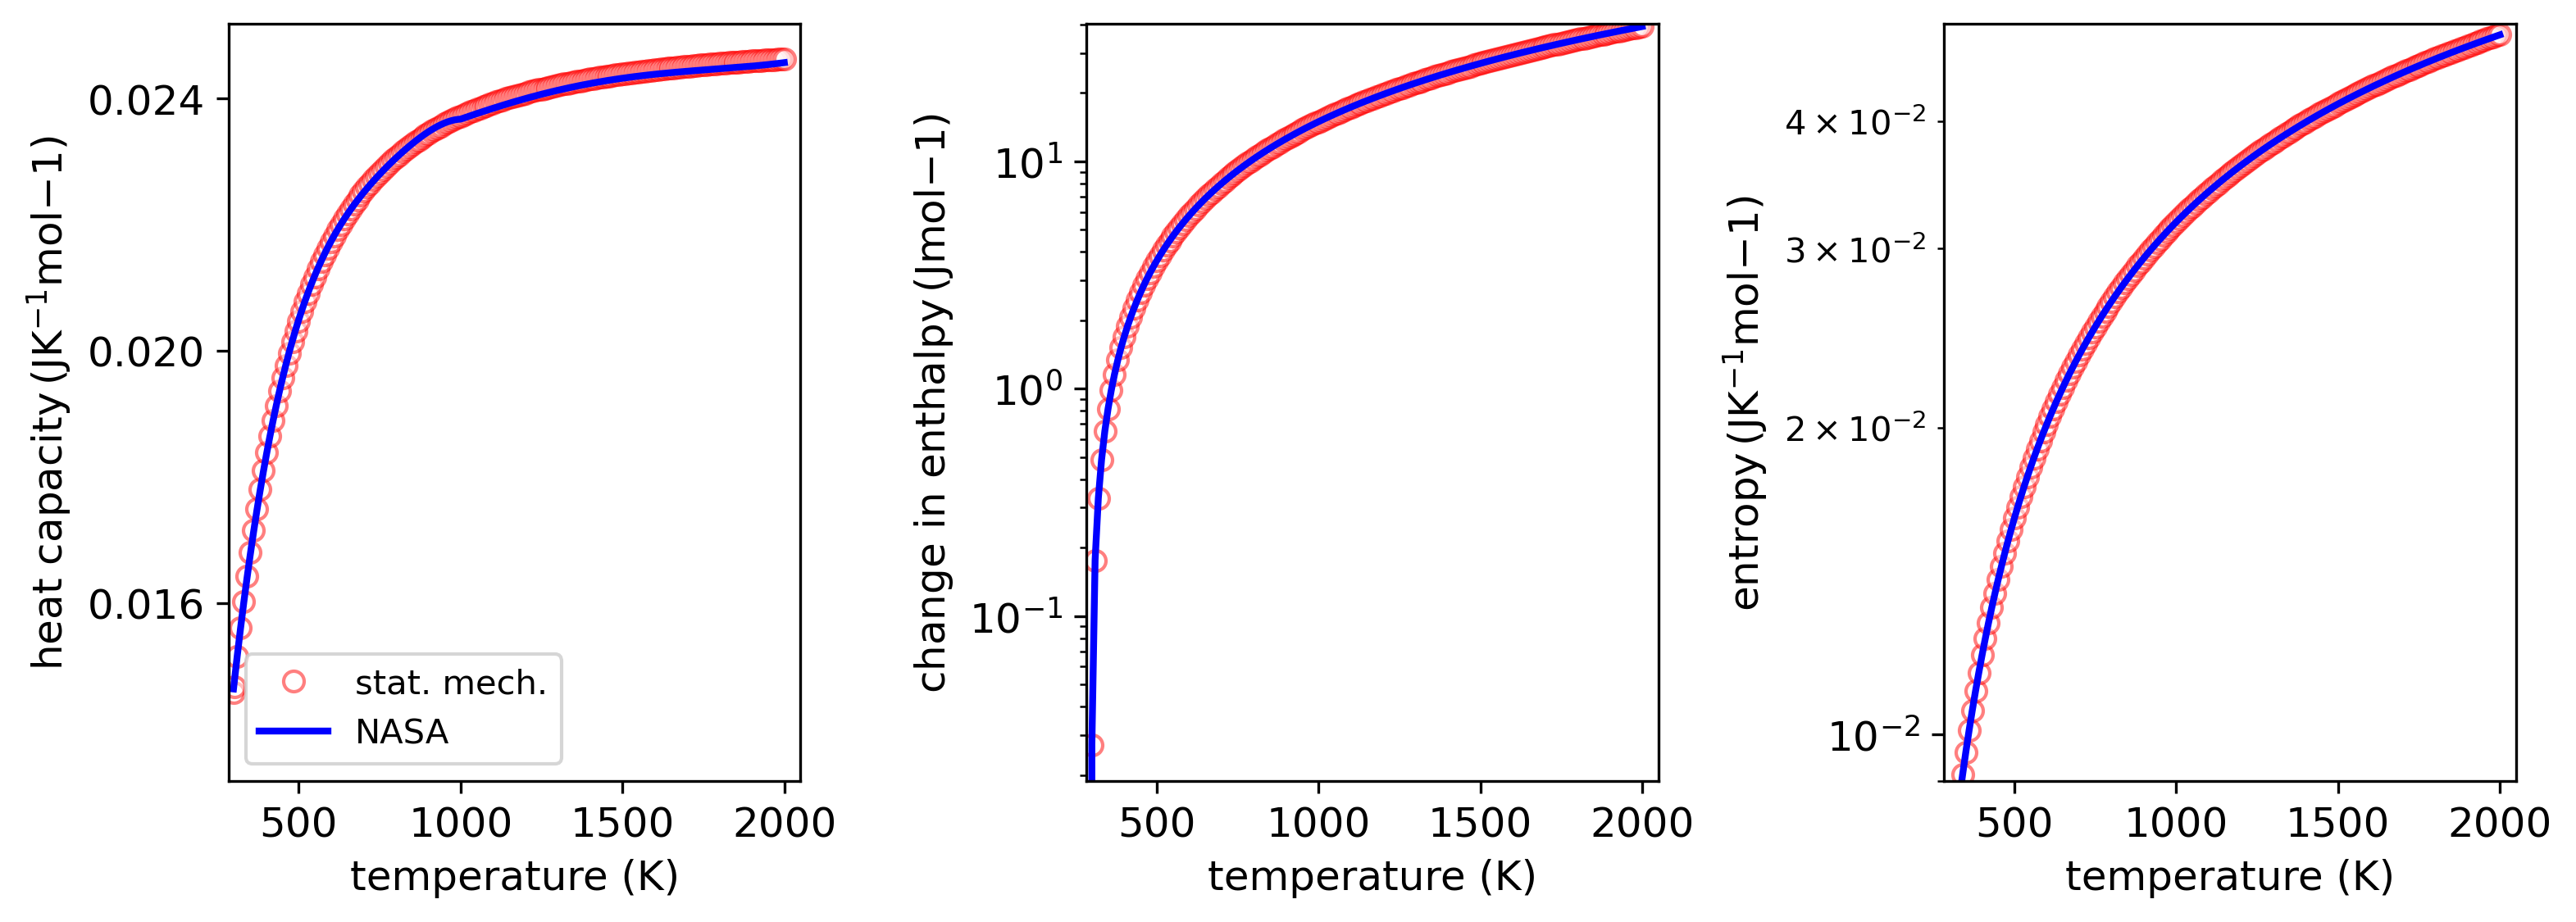

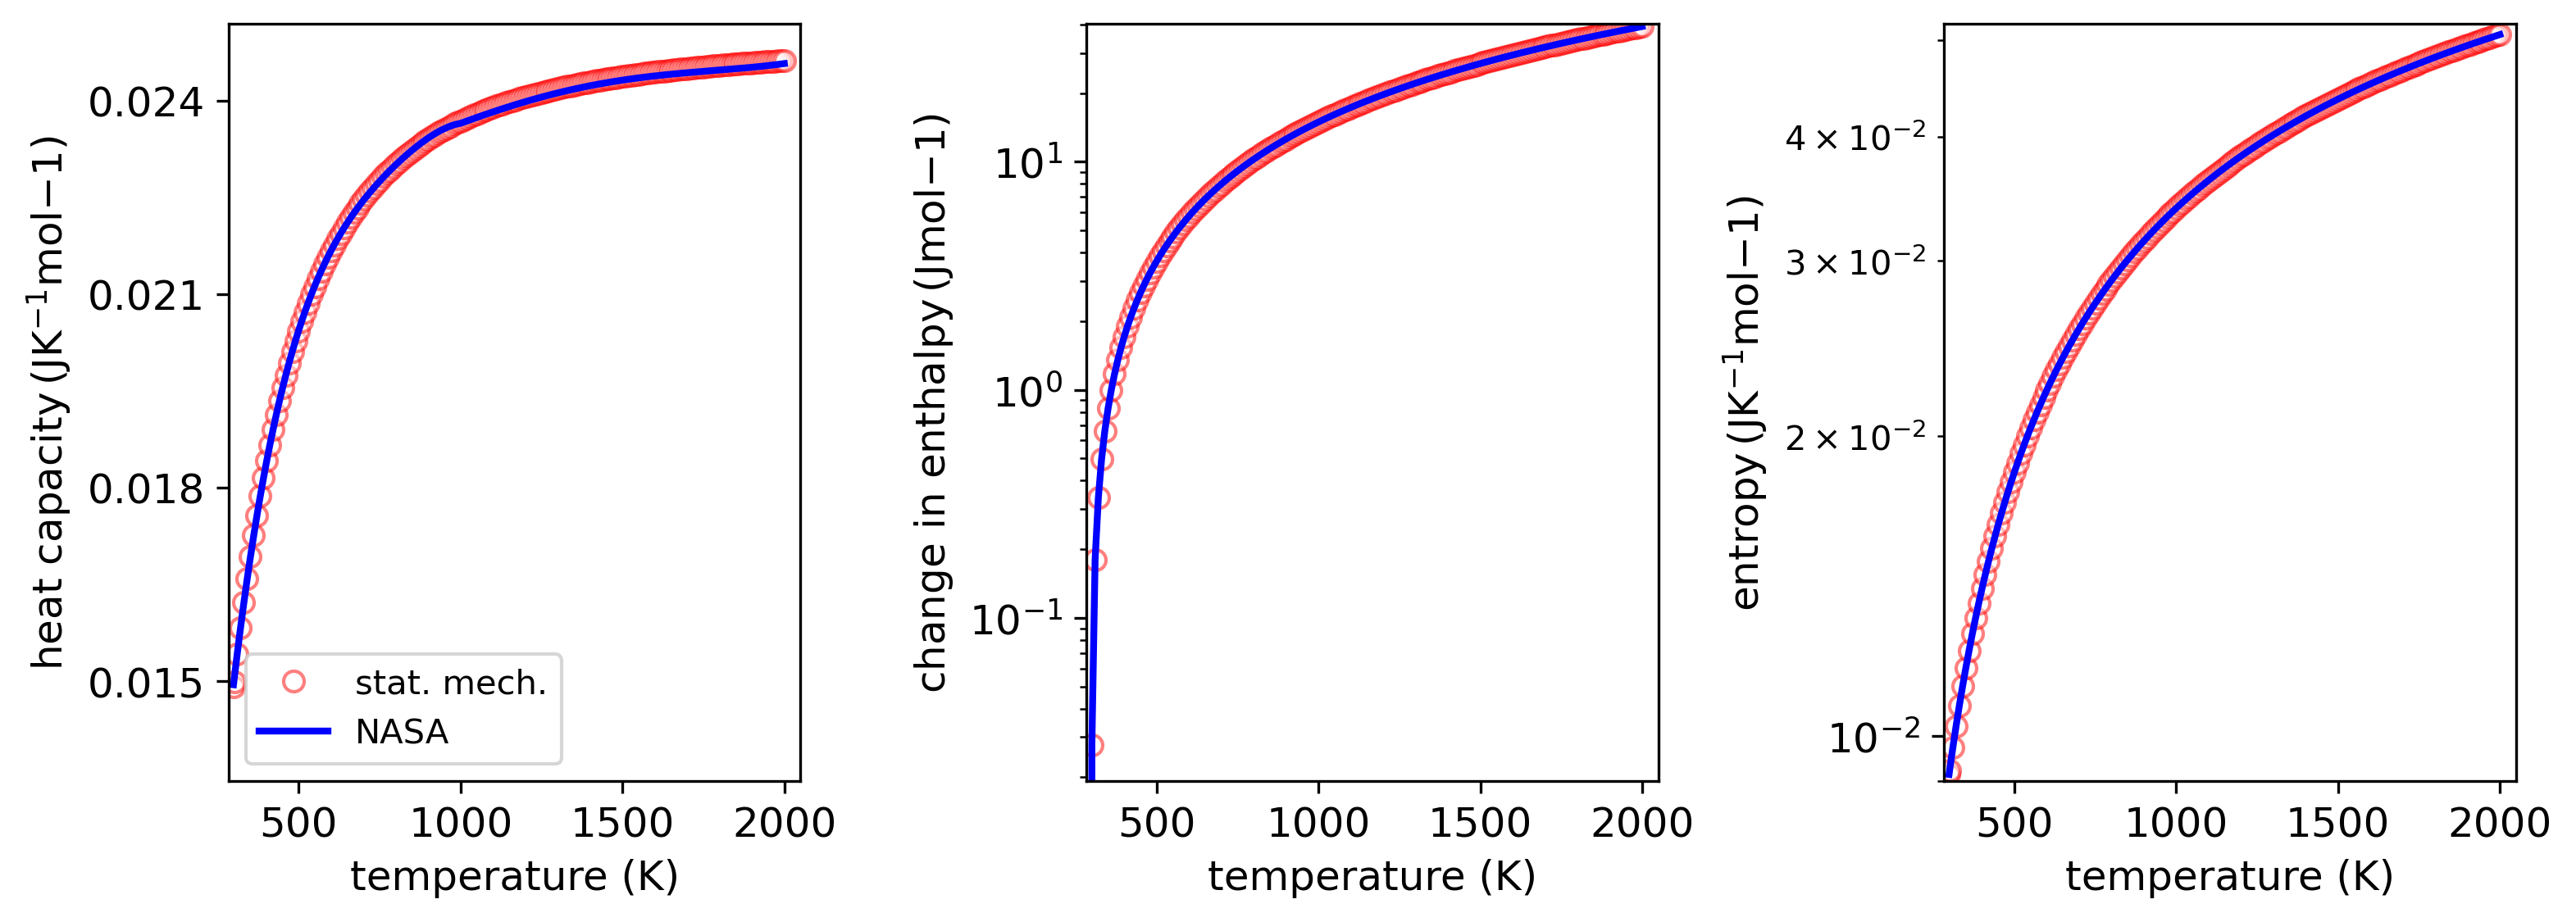

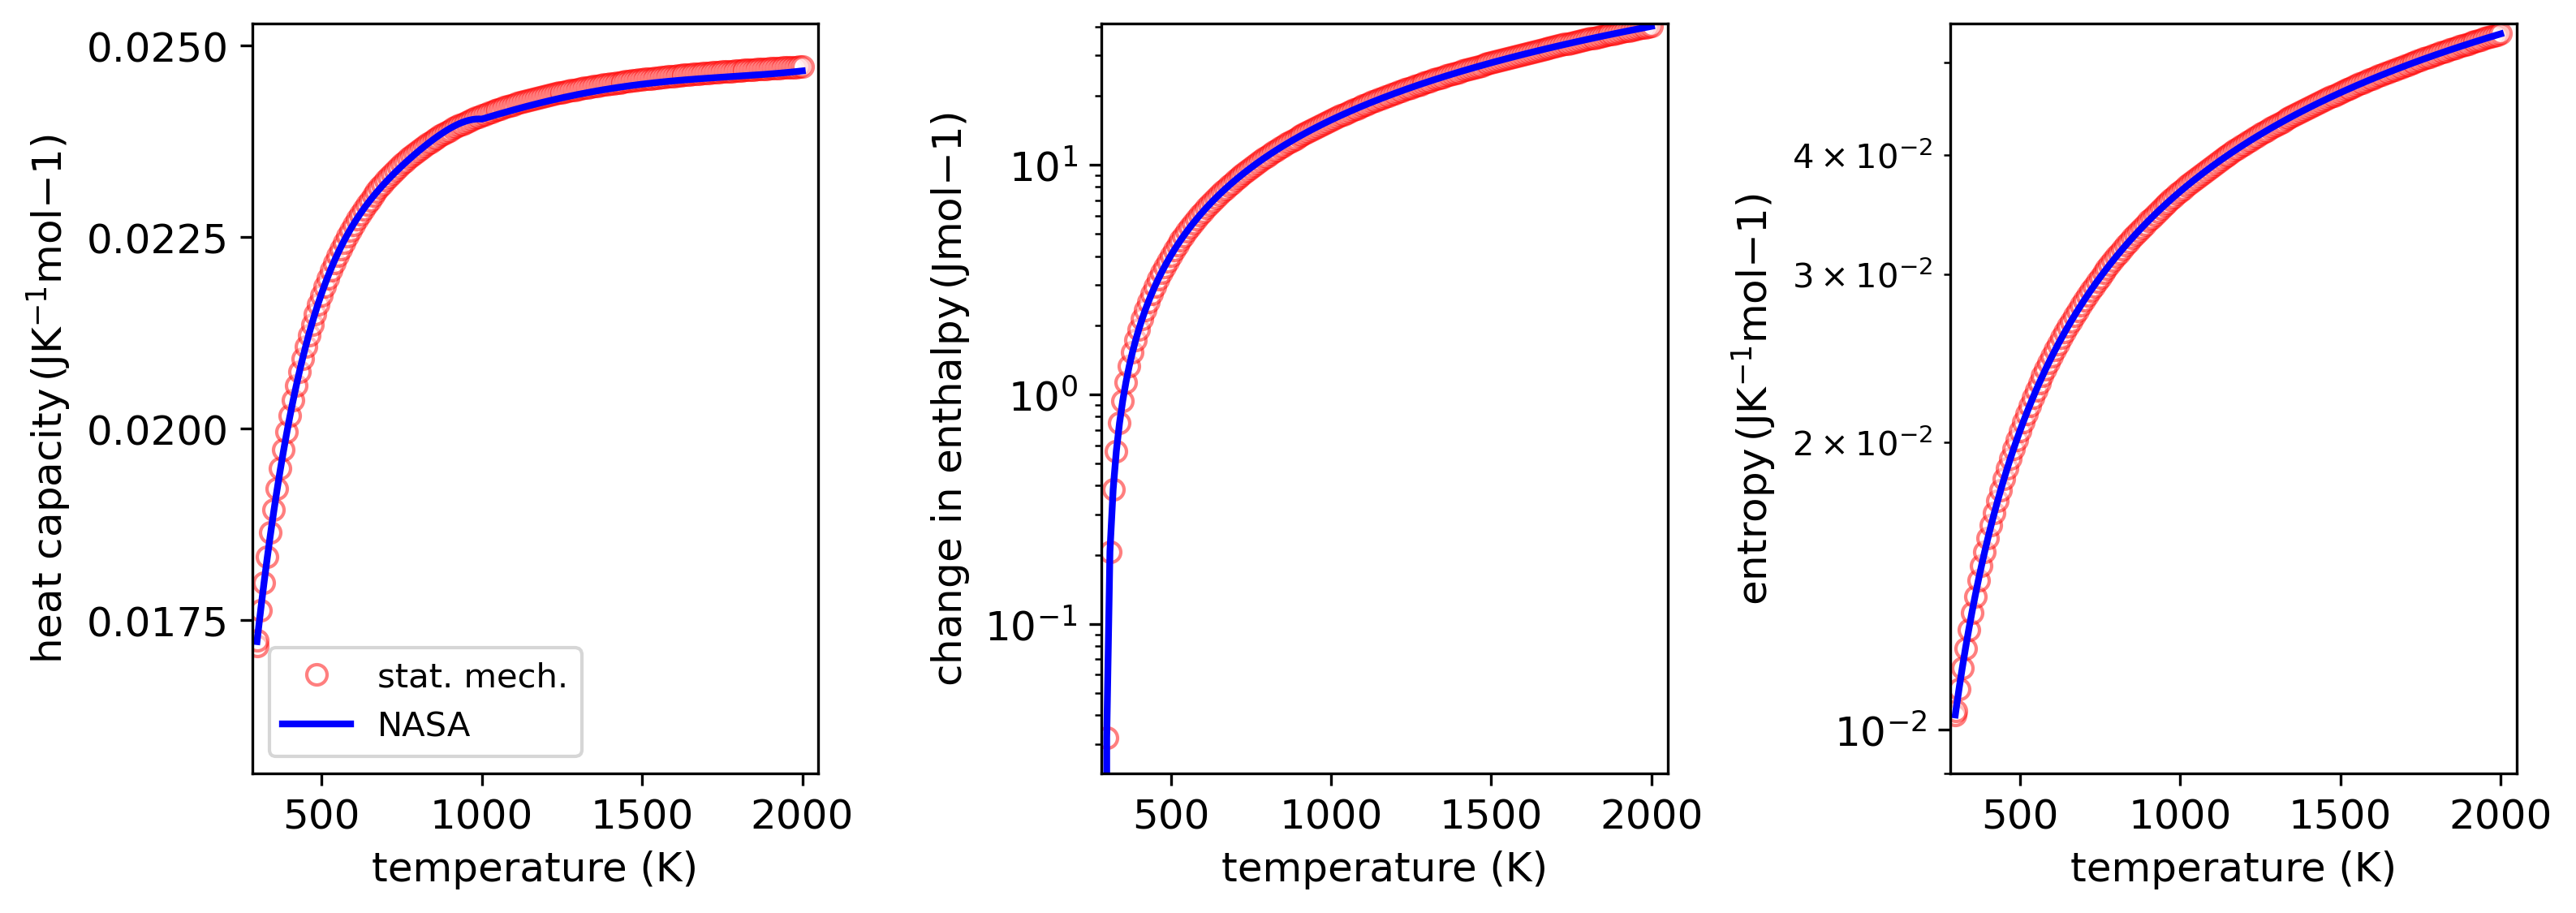

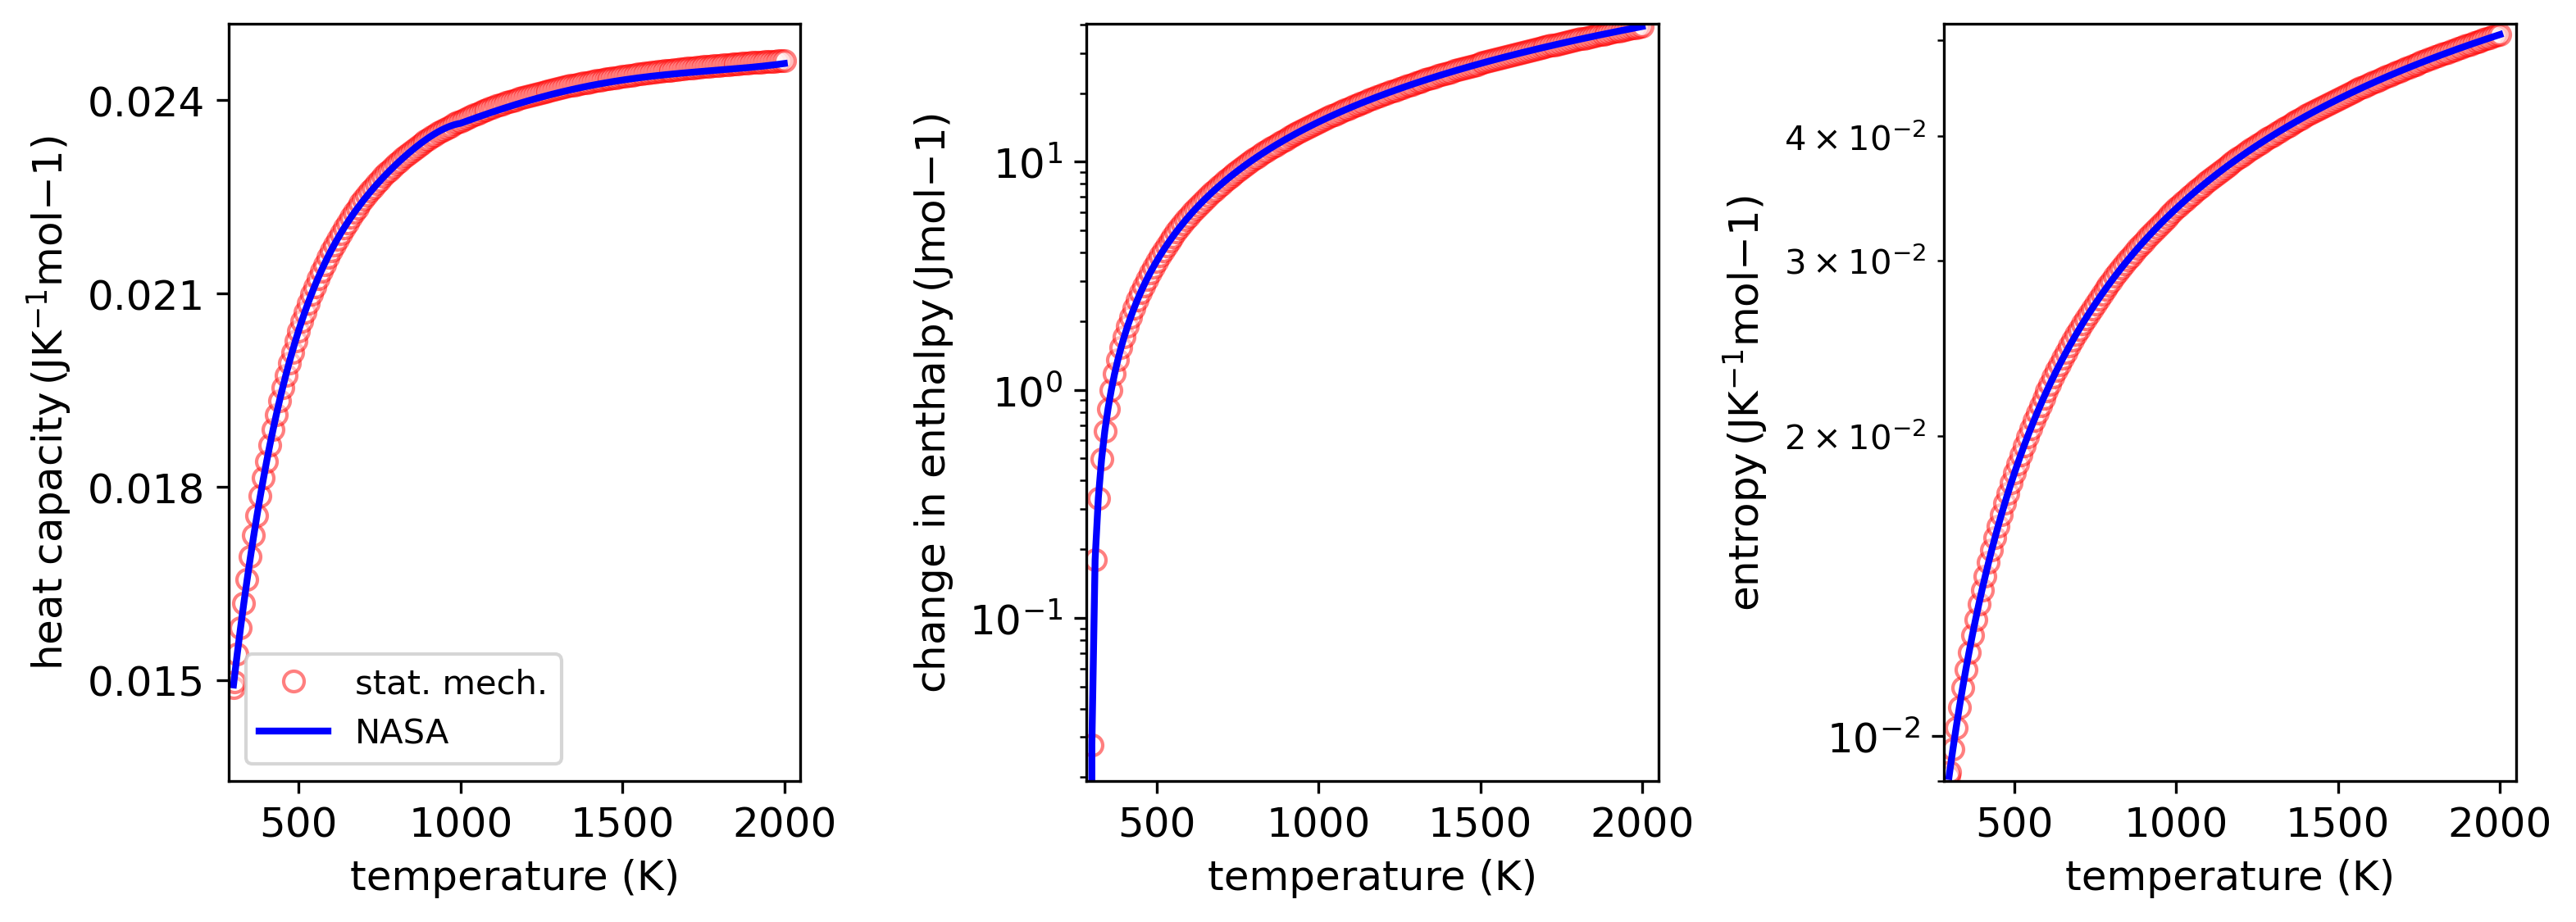

In [4]:
list_of_species = 'species_list_C.dat'
info = open(list_of_species,'r')
species_list = info.readlines()
info.close()

#This is the name of the output file
new_output = open('my_new_cti.txt', 'w')

name_line = '\n'
species_line = '\n'

counter = -1
for species in species_list:
    counter += 1
    filename = species.strip()
    print(filename)
    
    test = Molecule()
    parse_input_file(filename, test)
    thermo(test, temperature)
    
    name_line += ' %s'%(test.name)
    if counter == 4:
        name_line +='\n'
        counter == -1
    species_line += test.species_lines
    
    get_thermo_from_NASA(temperature, test)
    compare_NASA_to_thermo(temperature, test)

name_line += '\n\n' 
new_output.write(name_line)
new_output.write(species_line)

new_output.close()  